In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

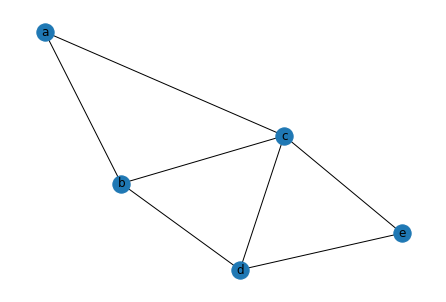

In [2]:
# Define a sample graph and its edge weights
G = nx.Graph()
weights = [('a', 'b', 4), ('a', 'c', 2), ('b', 'c', 5), ('b', 'd', 10), ('c', 'd', 3), ('d', 'e', 7), ('c', 'e', 8)]
G.add_weighted_edges_from(weights)

nx.draw(G, with_labels=True)


In [3]:
cweight = { (i,j) : d['weight'] for i,j,d in G.edges(data=True) }
cweight

{('a', 'b'): 4,
 ('a', 'c'): 2,
 ('b', 'c'): 5,
 ('b', 'd'): 10,
 ('c', 'd'): 3,
 ('c', 'e'): 8,
 ('d', 'e'): 7}

In [4]:
# Kruskal's algorithm with networkx
mst_kruskal = nx.minimum_spanning_edges(G, weight='weight', algorithm='kruskal', data=True)

edges_sol = []
edges_sol_dic = {}
value_sol = 0
for u, v, d in mst_kruskal:
    e = tuple((u,v))
    edges_sol_dic[e] = d["weight"] 
    edges_sol.append(e)
    value_sol += d["weight"]

In [5]:
mst_kruskal = nx.minimum_spanning_edges(G, weight='weight', algorithm='kruskal', data=True)
kruskal_weight = sum(d['weight'] for u, v, d in mst_kruskal)
print(f"Kruskal's algorithm total weight: {kruskal_weight}")

Kruskal's algorithm total weight: 16


In [6]:
#print(u,v,d['weight'])
print(f"solution = {edges_sol_dic}")
print(f"value = {value_sol}")

solution = {('a', 'c'): 2, ('c', 'd'): 3, ('a', 'b'): 4, ('d', 'e'): 7}
value = 16


In [7]:
nodes = G.nodes()
nodes

NodeView(('a', 'b', 'c', 'd', 'e'))

In [8]:
edges = G.edges()
edges

EdgeView([('a', 'b'), ('a', 'c'), ('b', 'c'), ('b', 'd'), ('c', 'd'), ('c', 'e'), ('d', 'e')])

In [9]:
# Create Gurobi model
model = gp.Model("MST")
model.setParam("LazyConstraints", 1) # Enable lazy constraints for cut formulation

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-19
Set parameter LazyConstraints to value 1


In [10]:
# Create binary variables for each edge
x = model.addVars(G.edges(), vtype=GRB.BINARY, name="x")
for i, j in G.edges():
    # Add a symmetric variable for undirected graph modeling
    x[j,i] = x[i,j] 

In [11]:
# Set objective: minimize total edge weight
model.setObjective(gp.quicksum(cweight[edge] * x[edge] for edge in G.edges()), GRB.MINIMIZE)
model.update()


In [12]:
# Constraint 1: Total number of edges in the MST must be n-1
n = len(G.nodes())
model.addConstr(gp.quicksum(x[edge] for edge in G.edges()) == n - 1, "TotalEdges")
model.update()


In [13]:
model._vars = model.getVars()

In [14]:
# Callback function to add cut constraints dynamically
def cut_callback(model, where):
    if where == GRB.Callback.MIPSOL:
        # Get the current solution values for the x variables
        x_vals = model.cbGetSolution(model._vars)#model.get_values_all()
            
        # Reconstruct the current solution's subgraph
        mst_edges = []
        for edge in G.edges():
            if x_vals[model.getVarByName(f"x[{edge[0]},{edge[1]}]").index] > 0.5:
                mst_edges.append(edge)
            
        # Check for connectivity using NetworkX
        subgraph = nx.Graph()
        subgraph.add_nodes_from(G.nodes())
        subgraph.add_edges_from(mst_edges)

        if not nx.is_connected(subgraph):
            # Find connected components and add a cut constraint for one of them
            components = list(nx.connected_components(subgraph))
            
            for S in components:
                if 0 < len(S) < n:
                    # Add cut constraint: sum of x for edges crossing the cut S must be >= 1
                    edges_crossing_cut = [(i, j) for i, j in G.edges() if (i in S and j not in S) or (j in S and i not in S)]
                    model.cbLazy(gp.quicksum(x[edge] for edge in edges_crossing_cut) >= 1)

                    return # Add one constraint per callback


In [15]:
# Optimize the model using the callback
model.optimize(cut_callback)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xea3bdae4
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)

Root relaxation: objective 1.400000e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   14.00000    0    -          -   14.00000

In [16]:
# Extract the resulting MST edges
if model.status == GRB.OPTIMAL:
    mst_edges = []
    for edge in G.edges():
        if x[edge].X > 0.5:
            mst_edges.append(edge)
    objval = model.ObjVal
    objbound = model.ObjBound 
    mipgap = model.MIPGap
    runtime = model.Runtime
    nodecount = model.NodeCount
else:
    print("Optimization failed or was not optimal.")

In [17]:
print(f"solution = {mst_edges}")
print(f"objval = {objval}")
print(f"objbound = {objbound}") 
print(f"mipgap = {mipgap}")
print(f"runtime = {runtime}")
print(f"nodecount = {nodecount}")


solution = [('a', 'b'), ('a', 'c'), ('c', 'd'), ('d', 'e')]
objval = 16.0
objbound = 16.0
mipgap = 0.0
runtime = 0.017857789993286133
nodecount = 1.0


In [18]:
model

<gurobi.Model MIP instance MST: 1 constrs, 7 vars, Parameter changes: Username=(user-defined), LazyConstraints=1>

In [19]:
# edge weight labels
pos = nx.spring_layout(G, seed=7)
edge_labels = nx.get_edge_attributes(G, "weight")
print(edge_labels)

{('a', 'b'): 4, ('a', 'c'): 2, ('b', 'c'): 5, ('b', 'd'): 10, ('c', 'd'): 3, ('c', 'e'): 8, ('d', 'e'): 7}


In [22]:
mst_edges

[('a', 'b'), ('a', 'c'), ('c', 'd'), ('d', 'e')]

In [20]:
T = nx.DiGraph()
T.add_edges_from(mst_edges)

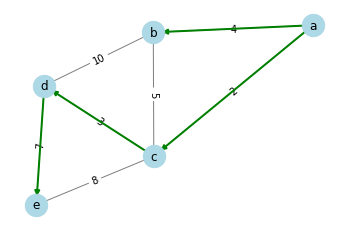

In [21]:
# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, pos, edge_color="grey")
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)})
nx.draw_networkx_edges(T, pos, edge_color="green", width=2)
plt.axis("off")
plt.show()

In [26]:
del model